In [1]:
import os
import sys
from datetime import datetime

In [2]:
# -------------------------------------------------------------
# Environment setup
# -------------------------------------------------------------
BASE_DIR = os.path.abspath("../")
sys.path.append(BASE_DIR)

# -------------------------------------------------------------
# Configuration
# -------------------------------------------------------------
from src.utils.config import load_config
config = load_config(base_dir=BASE_DIR)

In [3]:
import time
import pandas as pd
import dask.dataframe as dd
from dask_ml.cluster import KMeans



# K-mean with dask_ml

We are using euclidean distance

In [4]:
start_time = time.time()

# Cargar datos
# tensors_normalized_L1 = config["paths"]["tensors_normalized_L1"]
tensors_normalized_L2 = config["paths"]["tensors_normalized_L2"]
# tensors_svd = config["paths"]["tensors_svd"]
data = dd.read_parquet(tensors_normalized_L2)

# Separar ID y features
ids = data.iloc[:, 0]
features_df = data.iloc[:, 1:].astype('float64')

# Convertir a Dask Array
features = features_df.to_dask_array(lengths=True)
print(f"Forma del array: {features.shape}")

# KMeans
k = 22
k = 42
kmeans = KMeans(
    n_clusters=k,
    init_max_iter=10,
    oversampling_factor=2,
    random_state=42
)

# Dask KMeans trabaja en bloques (sin saturar la memoria)
kmeans.fit(features)

# predecir clusters
labels = kmeans.predict(features)



end_time = time.time()
print(f"⏰ Start: {time.ctime(start_time)}")
print(f"🏁 End:   {time.ctime(end_time)}")
print(f"⏱️ Total: {end_time - start_time:.2f} sec ({(end_time - start_time)/60:.2f} min)")

Forma del array: (26283914, 30)


Found fewer than 42 clusters in init (found 21).


⏰ Start: Thu Nov 27 20:40:26 2025
🏁 End:   Fri Nov 28 00:00:01 2025
⏱️ Total: 11974.81 sec (199.58 min)


In [5]:
labels_dask_series = dd.from_dask_array(
    labels,
    columns=['cluster_label']
)
# labels_dask_series = labels_dask_series.set_divisions(*ids.divisions)

results = dd.merge(
    ids.to_frame(),
    labels_dask_series,
    left_index=True,
    right_index=True,
    how="left"
)

# labels
cluster_labels = config["paths"]["cluster_labels"]
os.makedirs(os.path.dirname(cluster_labels), exist_ok=True)
results.to_parquet(cluster_labels, write_index=False)
print(f"Clusters labels guardados en {cluster_labels}")


# centroides
centroids = pd.DataFrame(kmeans.cluster_centers_)
cluster_centroids = config["paths"]["cluster_centroids"]
os.makedirs(os.path.dirname(cluster_centroids), exist_ok=True)
centroids.to_csv(cluster_centroids, index=True)
print(f"Clusters centroids guardados en {cluster_centroids}")

results.head()

Clusters labels guardados en /Users/jkn/Documents/Projects/university/tensor_behavioral_pattern_mining/data/processed/visa_trx/cluster_labels
Clusters centroids guardados en /Users/jkn/Documents/Projects/university/tensor_behavioral_pattern_mining/data/processed/visa_trx/cluster_centroids.csv


,row_id,cluster_label
501,HPvZlfEGXzQ=_3,6
720,HPwizDF7uiA=_1,39
1057,HQ+QetD9xYk=_34,25
1404,HQ1s/9whisY=_13,0
1803,HQ9AF+O1u1s=_10,34


In [6]:
centroids.head()

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
0,-0.145034,0.450029,-0.127742,-0.249068,0.450606,0.119174,-0.267836,0.115513,0.094458,0.080223,...,0.020370,0.017119,-0.052158,0.163824,0.025946,0.005600,0.022028,0.000423,-0.017611,0.014876
1,-0.586739,0.106964,0.055478,0.177009,-0.201101,-0.104764,0.145694,-0.183160,-0.216607,0.092427,...,-0.084020,-0.130333,-0.031184,-0.072858,0.125249,0.025147,-0.044571,0.056182,-0.000984,0.004717
2,0.027645,0.197389,-0.035046,-0.123736,0.327046,-0.165831,0.062248,-0.248659,-0.273479,-0.072550,...,-0.014075,-0.065100,0.007038,0.028110,-0.000037,0.033837,-0.023345,-0.008386,-0.007643,0.002555
3,-0.250748,-0.446385,0.226747,0.067228,-0.091311,-0.181435,-0.389202,-0.102458,0.160784,0.215708,...,0.051725,0.027344,0.051418,0.056293,-0.000634,-0.001788,-0.122426,0.009037,0.014964,-0.015923
4,-0.296131,-0.284614,-0.529647,-0.107025,-0.253493,0.298519,0.012170,0.057652,-0.079112,0.140370,...,-0.026184,0.044545,0.078333,0.060837,0.038476,-0.010630,-0.069155,0.014538,0.033171,-0.040980


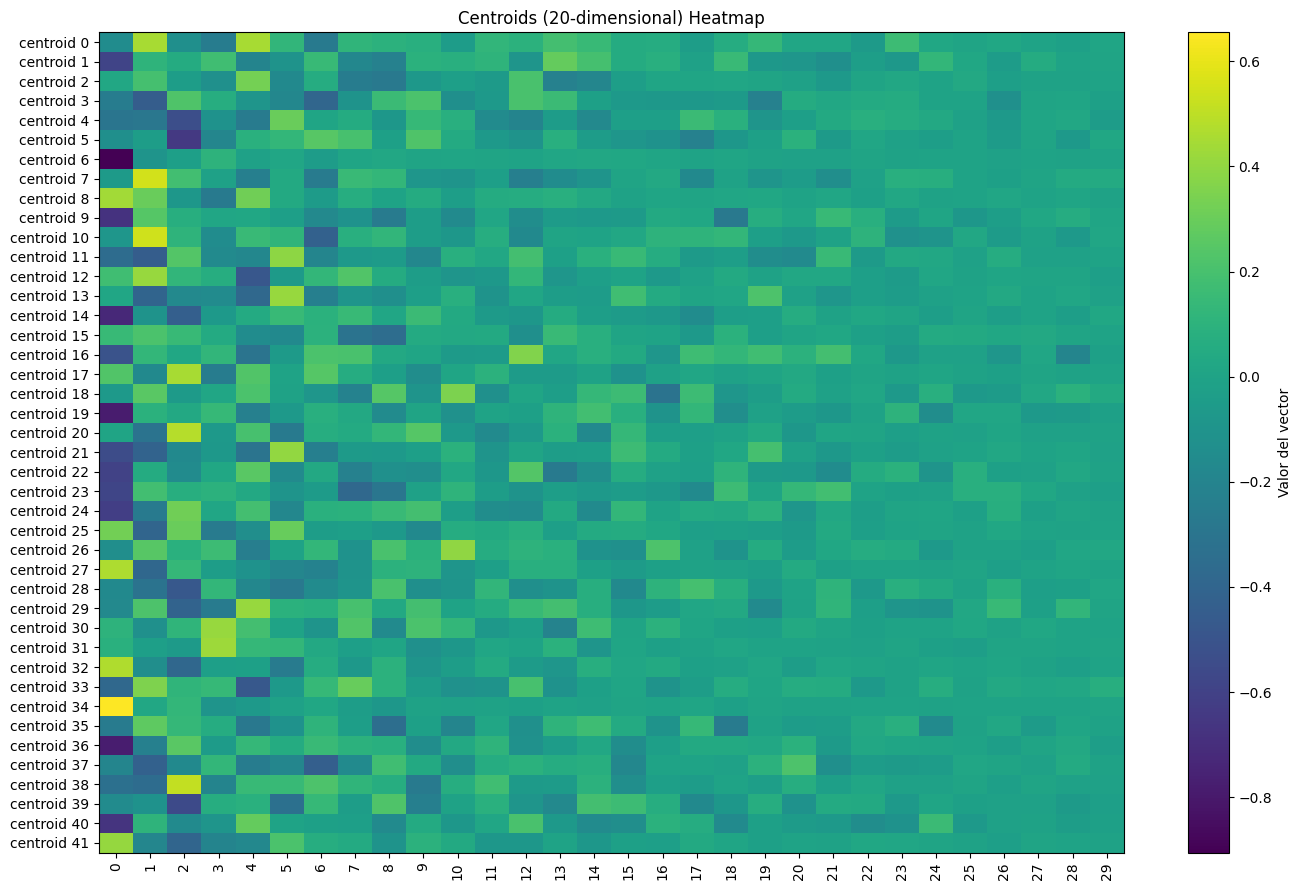

In [12]:
import matplotlib.pyplot as plt
import numpy as np

centroids_df = centroids

data = centroids_df.values
cols = centroids_df.columns
rows = centroids_df.index.astype(str)

plt.figure(figsize=(14, 9))

# Heatmap
plt.imshow(data, aspect='auto')
plt.colorbar(label="Valor del vector")

# Ejes
plt.xticks(ticks=np.arange(len(cols)), labels=cols, rotation=90)
plt.yticks(ticks=np.arange(len(rows)), labels=[f"centroid {r}" for r in rows])

plt.title("Centroids (20-dimensional) Heatmap")
plt.tight_layout()
plt.show()

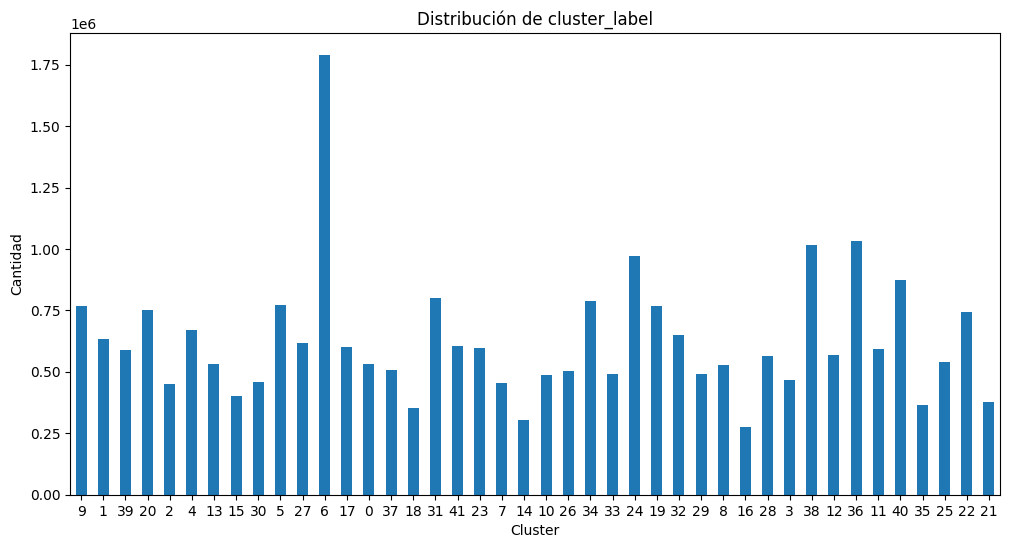

In [13]:
import dask.dataframe as dd
import matplotlib.pyplot as plt

cluster_labels = config["paths"]["cluster_labels"]
data = dd.read_parquet(cluster_labels)

# Contar clusters
cluster_counts = data["cluster_label"].value_counts().compute()

# Graficar
plt.figure(figsize=(12, 6))
cluster_counts.plot(kind='bar')

plt.title("Distribución de cluster_label")
plt.xlabel("Cluster")
plt.ylabel("Cantidad")
plt.xticks(rotation=0)
plt.show()


In [9]:
jkn

NameError: name 'jkn' is not defined

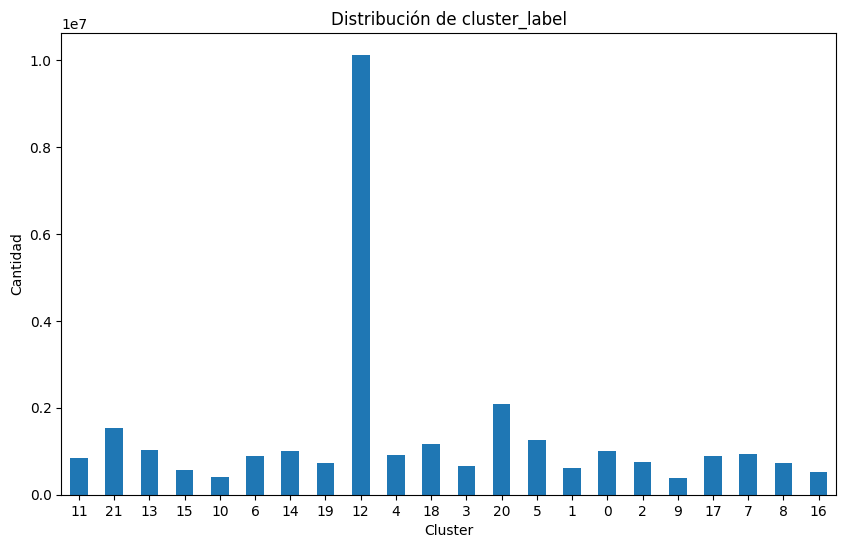

In [ ]:
import dask.dataframe as dd
import matplotlib.pyplot as plt

cluster_labels = config["paths"]["cluster_labels"]
data = dd.read_parquet(cluster_labels)

# Contar clusters
cluster_counts = data["cluster_label"].value_counts().compute()

# Graficar
plt.figure(figsize=(10, 6))
cluster_counts.plot(kind='bar')

plt.title("Distribución de cluster_label")
plt.xlabel("Cluster")
plt.ylabel("Cantidad")
plt.xticks(rotation=0)
plt.show()
